## **Notebook for analysing nf pipeline output**

### **Packages**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob, os, re
import pprint
import matplotlib.pyplot as plt
from datetime import  datetime
from ipywidgets import widgets, interactive

In [2]:
dt = datetime.today().strftime(format='%d-%m-%Y')

### **Directories & Files**
Uniqueness in directory and file names is assumed for all analyses

The organisation of the `run_dir`: The directory name MUST be unique and reside anywhere inside `sars_dir` directory
 
| Directory name | File name | File source-tool | File description |
| :-------------- | :--------- | :---------------- | :------|
|qcs *(QCs)*|`*.tsv`|Quast|Transposed report|
|nxt *(nextclade)*|`nxt.tsv`|Nextclade|Renamed `nextclade.tsv` output|
|snpEff|`*sneff.vcf`| snpEff|Per-sample unzipped `snpEff` output|
|var *(variants)*|`k-per-gene_variant_anns.tsv`|Script: `abstract_snpeff_ann_output.py`|Aggregation of individual `snpEff.vcf` outputs by abstracting gene-mutations|
|png *(pangolin)*|`png.csv`|Pangolin|Renamed `Pangolin result.csv` output|
|dpt *(coverage depths)*|`amplicon, genome`|Mosdepth|Per-sample amplicon/genome depths<br> ***Cols**:chrom, start, end, region, coverage, sample*|
|plt *(plot)*|`*.pdf`|Quast|Heatmap plot for median read depth coverage|

### **Preliminary variables**

In [3]:
sars_dir = 'SARS-CoV-2' #  name of root directory for all SARS-associated work
home_dir = os.getenv('HOME') #  get OS home directory
parent_dir = glob.glob(f'{home_dir}/**/{sars_dir}', recursive=True)[0]

### **Metadata**

In [4]:
# import raw metadata file
df_rmd_cln = pd.read_excel(glob.glob(f'{parent_dir}/**/Outputs/COVID19-resultsCts-merged-cln.xlsx', recursive=True)[0]).drop('abbr', axis=1)

In [5]:
#df_rmd_cln.head()

### **Functions**

In [6]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [7]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [8]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [9]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [10]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [11]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [12]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [13]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0].split('.')[0]))
    return df_fnl

In [14]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    elif 'AY' in str(x):
        return str(x).replace(str(x), str(x) + '(Delta)')
    elif x == 'B.1.1.529':
        return x.replace(x, 'B.1.1.529(Omicron)')
    elif 'BA' in str(x):
        return str(x).replace(str(x), str(x) + '(Omicron)')
    return x
    

In [15]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

### **Variables**

Reassign accordingly...

In [16]:
seq_name = 'seq41'#seq*
tech = 'NextSeq'#NextSeq/MiSeq/MinION
seq_dt = '13/04/2022'#DD/MM/YYYY
lib_prep = 'COVIDSeq'#NEBNext/NEBNext_FS/COVIDSeq/Nextera_XT
primer_set = 'ARTIC_V3'#ARTIC_V3/ARTIC_V4
identifier = 'ILL_seq41' #used in naming file outputs
run_dir = 'output_2022-04-13_run41_nextseq' #name of the run directory containing viralcon pipeline output as implemented by Kibet

### **Depth plots**

### **Variants data**

In [17]:
# import the collated file for all the snpEff outputs
df_var = pd.read_csv(f"{glob.glob(f'{parent_dir}/**/{run_dir}/var', recursive=True)[0]}/k-per-gene_variant_anns.tsv", sep='\t')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0].split('.')[0]))

In [18]:
df_var_fnl.head(2)

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVM03166,49,"NC, S216S, F924F, P927L, T1001I, A1708D, I2230...",NaN,"H69_V70del, Y145del, L452R, T478K, E484Q, A570...","S26L, P240L",NaN,NaN,NaN,NaN,NaN,NaN,"NC, Q27*, R52I, V62V, Y73C","NC, D3L, S235F",NaN,NaN,NaN
1,COVM03068,49,"NC, NC, A735A, K856R, F924F, V1211F, A1707A, S...",NaN,"A67V, H69_V70del, T95I, G142_Y145delinsD, K417...","V55F, T64T",NaN,T9I,"NC, D3G, Q19E, A63T",R20R,NaN,NaN,"NC, NC","NC, P13L, E31_S33del, R203K, G204R",NaN,NaN,NaN


### **Genome fraction**

In [19]:
# import the collated file for all the multiqc output
df_qcs_trans_cols = ['sample_name', 'Genome fraction (%)']#, 'Assembly'
df_qcs_trans = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/qcs/transposed_report.tsv', recursive=True)[0])
df_qcs_trans2 = df_qcs_trans.assign(sample_name = df_qcs_trans['Assembly'].apply(lambda x: x.split('.')[0].split('_')[0]))[df_qcs_trans_cols].rename(columns={'Genome fraction (%)': 'genome_cov'})
df_qcs_trans_fnl = df_qcs_trans2.assign(genome_cov=df_qcs_trans2['genome_cov'].replace('-', np.nan).apply(lambda x: round(float(x),1) if float(x) else np.nan)).rename(columns={'genome_cov': 'Genome fraction (%)', 'sample_name': 'seqName'})

### **Nextclade data**

In [20]:
# import Nextclade clade data
df_nxt = pd.read_table(glob.glob(f'{parent_dir}/**/{run_dir}/nxt/nxt.tsv', recursive=True)[0])

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade']
df_nxt_cln = get_cols(df_nxt, cols)
# coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[1].split('.')[0] if len(x.split('_')) > 2 else x.split('/')[0]))
df_nxt_fnl = df_nxt_cln1.merge(df_qcs_trans_fnl, how='outer', left_on='seqName', right_on='seqName')

In [21]:
df_nxt_fnl.head(2)

,seqName,clade,Genome fraction (%)
0,COVM03032,21J (Delta),98.8
1,COVM03033,21J (Delta),97.9


### **Pangolin data**

In [22]:
# import Pangolin lineage data
df_png = pd.read_csv(glob.glob(f'{parent_dir}/**/{run_dir}/png/png.csv', recursive=True)[0])
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
# cols = ['taxon', 'lineage', 'scorpio_call']#, 'Most_common_countries']
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = (df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].
                                apply(lambda x: x.split('_')[1].split('.')[0] if len(x.split('_')) > 2 else x.split('/')[0])))
#               drop('Sequence_name', axis=1))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [23]:
df_png_fnl.head(2)

,Sequence_name,Lineage,Scorpio_call
0,COVM03032,B.1.617.2,Delta (B.1.617.2-like)
1,COVM03033,B.1.617.2,Delta (B.1.617.2-like)


### **Combining data**

#### *Merge Variants and Nextclade data*

In [24]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [25]:
df_varNxt.head(2)

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,Genome fraction (%)
0,COVM03032,44,"NC, NC, L469F, F924F, A1306S, P2046L, P2287S, ...",NaN,"T19R, T95I, G142D, E156_R158delinsG, L452R, T4...",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,"NC, V13V, D119_F120del, F120L","NC, D63G, R203M, G215C, D377Y",NaN,NaN,NaN,21J (Delta),98.8
1,COVM03033,43,"NC, NC, L469F, F924F, A1306S, P2046L, P2287S, ...",NaN,"T19R, S151I, E156_R158delinsG, L452R, T478K, D...",S26L,NaN,NaN,I82T,NaN,"V82A, T120I",NaN,"NC, V13V, D119_F120del, F120L","NC, D63G, R203M, G215C, D377Y",NaN,NaN,NaN,21J (Delta),97.9


#### *Merge pango and var-nextclade data*

In [26]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [27]:
df_pngVxt.head(2)

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,Genome fraction (%)
0,COVM03032,B.1.617.2,Delta (B.1.617.2-like),44,"NC, NC, L469F, F924F, A1306S, P2046L, P2287S, ...",NaN,"T19R, T95I, G142D, E156_R158delinsG, L452R, T4...",S26L,NaN,NaN,...,NaN,"V82A, T120I",NaN,"NC, V13V, D119_F120del, F120L","NC, D63G, R203M, G215C, D377Y",NaN,NaN,NaN,21J (Delta),98.8
1,COVM03033,B.1.617.2,Delta (B.1.617.2-like),43,"NC, NC, L469F, F924F, A1306S, P2046L, P2287S, ...",NaN,"T19R, S151I, E156_R158delinsG, L452R, T478K, D...",S26L,NaN,NaN,...,NaN,"V82A, T120I",NaN,"NC, V13V, D119_F120del, F120L","NC, D63G, R203M, G215C, D377Y",NaN,NaN,NaN,21J (Delta),97.9


In [28]:
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### *Merge sequence/var-nxt-png (pngVxt) and  metadata (df_rmd_cln)*

In [29]:
# merge metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmd_cln)

### **QC whether all samples sequenced had metadata**

In [30]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmd_cln['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'Undetermined'}


### **Re-order df_vnpPmd columns and export merged metadata and sequencing data**

In [31]:
header_MS = ['CASE_ID', 'S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'VACC_STATUS', 'VACC_DOS', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [32]:
header_policy = ['CASE_ID', 'S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [33]:
# export limited metadata
df_vnpPmd_fnl1 = df_vnpPmd[header_policy].sort_values('S_NUM').drop_duplicates('S_NUM')
df_vnpPmd_fnl1[['SEQ#', 'SEQ_MCHN', 'DT_SEQ', 'LIB_KIT', 'PRM_SET']] = [seq_name, tech, seq_dt, lib_prep, primer_set]
(df_vnpPmd_fnl1
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-M-{identifier}_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [34]:
# export full metadata
df_vnpPmd_fnl = df_vnpPmd[header_MS].sort_values('S_NUM').drop_duplicates('S_NUM')
df_vnpPmd_fnl[['SEQ#', 'SEQ_MCHN', 'DT_SEQ', 'LIB_KIT', 'PRM_SET']] = [seq_name, tech, seq_dt, lib_prep, primer_set]
(df_vnpPmd_fnl
.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/metadata-seq-MS-{identifier}_{dt}.xlsx"
                     , index=False, na_rep='NA', float_format='%.1f'))
# df_vnpPmd_fnl.head()

### **CDC VoI**

In [35]:
omicron = ['A67V', 'del69-70', 'T95I', 'del142-144', 'Y145D', 'del211', 'L212I', 'ins214EPE', 'G339D', 'S371L', 'S373P', 'S375F', 
           'K417N', 'N440K', 'G446S', 'S477N', 'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H', 'T547K', 'D614G', 
           'H655Y', 'N679K', 'P681H', 'N764K', 'D796Y', 'N856K', 'Q954H', 'N969K', 'L981F']
gamma = ['L18F', 'T20N', 'P26S', 'D138Y', 'R190S', 'K417T', 'E484K', 'N501Y', 'D614G', 'H655Y', 'T1027I']
delta = ['T19R', '(V70F*)', 'T95I', 'G142D', 'E156-', 'F157-', 'R158G', '(A222V*)', '(W258L*)', '(K417N*)', 
         'L452R', 'T478K', 'D614G', 'P681R', 'D950N']
beta = ['D80A', 'D215G', '241del', '242del', '243del', 'K417N', 'E484K', 'N501Y', 'D614G', 'A701V']
alpha = ['69del', '70del', '144del', '(E484K*)', '(S494P*)', 'N501Y', 'A570D', 'D614G', 'P681H', 'T716I', 'S982A', 'D1118H', '(K1191N*)']

### **CDC VoC**

In [36]:
B16173 = ['T19R', 'G142D', 'L452R', 'E484Q', 'D614G', 'P681R', 'D950N']
kappa = ['(T95I)', 'G142D', 'E154K', 'L452R', 'E484Q', 'D614G', 'P681R', 'Q1071H']
iota = ['L5F', '(D80G*)', 'T95I', '(Y144-*)', '(F157S*)', 'D253G', '(L452R*)', '(S477N*)', 
        'E484K', 'D614G', 'A701V', '(T859N*)', '(D950H*)', '(Q957R*)']
eta = ['A67V', '69del', '70del', '144del', 'E484K', 'D614G', 'Q677H', 'F888L']

In [37]:
x = (set(gamma).union(set(delta)).union(set(beta)).union(set(alpha))).union(set(B16173).union(set(kappa)).union(set(iota)).union(set(eta)))
# x

### **Variants of Concern or under investigation**
 - N501Y (B.1.1.7): UK variant (Alpha)
 - N501Y, E484K, *K417N (B.1.351): SA variant (Beta)
 - N501Y, E484K (P.1): Brazilian variant (Gamma)
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant (Delta)
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple (Eta)
 - L5F, T95I, D253G, A701V (B.1.526): USA (Iota)
 - G142D, E154K, Q1071H ('B.1.617.1'): Indian (Kappa)

In [38]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L', 'L5F', 'D253G', 'E154K', 'A67V',
           'D614G', 'D796Y', 'E484A', 'G339D', 'G446S', 'G496S', 'H655Y', 'L212I', 'L981F', 'N440K', 'N679K', 'N764K', 'N856K',
           'N969K', 'P681H', 'Q493R', 'Q498R', 'Q954H', 'S371L', 'S373P', 'S375F', 'S477N', 'T478K', 'T547K', 'T95I', 'Y145D',
           'Y505H',  'del142-144', 'del211', 'del69-70', 'ins214EPE', 'R346K']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [39]:
df_moc.head(2)

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,COVM03166,"D614G, A570D, E484Q, L452R, T478K, P681H","Y145del, L452R, T478K, E484Q, A570D, T572I, D6..."
1,COVM03068,"D796Y, L981F, N679K, N764K, K417N, D614G, H655...","H69_V70del, T95I, G142_Y145delinsD, K417N, T54..."


### **Subsample brief data**

In [40]:
# reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

In [41]:
# filter reporting coverage (>=70)
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 70]

In [42]:
# df_brief.head()

### **Merge df_brief with df_moc**

In [43]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']  # removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### **Policy brief report**

In [44]:
# rename columns
cols = ['Sequence Name', 'Coverage', 'Date Collection (yyyy-mm-dd)', 'Date Received (yyyy-mm-dd)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [45]:
# df_brfMoc_fnl.head()

### **Reformat dates for KB**

In [46]:
df_brfMoc_fnl['Date Collection (yyyy-mm-dd)'] = (df_brfMoc_fnl['Date Collection (yyyy-mm-dd)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [47]:
df_brfMoc_fnl['Date Received (yyyy-mm-dd)'] = (df_brfMoc_fnl['Date Received (yyyy-mm-dd)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [48]:
df_report_fnl = df_brfMoc_fnl

In [49]:
# df_report_fnl.head()

In [50]:
df_report_fnl.to_excel(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-brief-T-{identifier}_{dt}.xlsx"
                     , index=False, na_rep='N/A', float_format='%.1f')

In [51]:
(df_report_fnl['Sample County of Origin'].value_counts())

Kassala        99
Khartum        46
Omdorman       30
Bahri          13
Jabal awlya     3
East nile       1
Elobyed         1
Whitenile       1
Eldoum          1
Um bada         1
Sinar           1
Name: Sample County of Origin, dtype: int64

### **Visualisation**

In [52]:
clr_code = {'TBA48': ('lime', '#00FF00'),
 'TBA01': ('gray', '#808080'),
 'TBA02': ('orangered', '#FF4500'),
 'TBA03': ('cyan', '#00FFFF'),
 'TBA05': ('chocolate', '#D2691E'),
 'TBA07': ('teal', '#008080'),
 'TBA09': ('slategray', '#708090'),
 'TBA11': ('orange', '#FFA500'),
 'TBA13': ('seagreen', '#2E8B57'),
 'TBA15': ('olive', '#808000'),
 'TBA17': ('honeydew', '#FFD700'),
 'TBA19': ('gold', '#8FBC8F'),
 'TBA24': ('aquamarine', '#006400'),
 'TBA25': ('yellowgreen', '#9ACD32'),
 'TBA26': ('tan', '#D2B48C'),
 'TBA27': ('indigo', '#4B0082'),
 'TBA28': ('mediumpurple', '#9370DB'),
 'TBA29': ('blue', '#0000FF'),
 'TBA30': ('darkslateblue', '#483D8B'),
 'TBA31': ('sienna', '#A0522D'),  #'TBA32': ('darkkhaki', '#BDB76B'),
 'TBA33': ('khaki', '#F0E68C'),
 'TBA34': ('dodgerblue', '#1E90FF'),
 'TBA35': ('palevioletred', '#DB7093'),
 'TBA36': ('yellow', '#FFFF00'),
 'TBA37': ('floralwhite', '#6495ED'),
 'TBA38': ('green', '#008000'),
 'TBA39': ('red', '#AFEEEE'),
 'TBA40': ('purple', '#800080'),
 'TBA41': ('brown', '#A52A2A'),
 'TBA42': ('chocolate', '#D2691E'),
 'TBA43': ('steelblue', '#4682B4'),
 'TBA44': ('magenta', '#FF00FF'),
 'TBA45': ('rosybrown', '#BC8F8F'),
 'TBA46': ('goldenrod', '#DAA520'),
 'TBA47': ('paleturquoise', '#FF0000'),
 'TBA10': ('lavender', '#E6E6FA'),
 'TBA12': ('pink', '#FFC0CB'),
 'TBA14': ('seashell', '#FFFAF0'),
 'TBA16': ('mediumvioletred', '#C71585'),
 'TBA18': ('black', '#000000'),  #'TBA2': ('cornflowerblue', '#FFF5EE'),
 'TBA20': ('saddlebrown', '#8B4513'),
 'TBA21': ('wheat', '#F5DEB3'),
 'TBA22': ('slategray', '#708090'),
 'TBA23': ('silver', '#C0C0C0'),
 'TBA04': ('midnightblue', '#191970'),
 'TBA06': ('darkgreen', '#7FFFD4'),
 'TBA08': ('darkseagreen', '#F0FFF0')}  #BLUES NEXT B.1.361
avail_clr = list(clr_code.keys())

In [53]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('Coverage', ascending=False))

In [54]:
max_count = grpby_lins['Sequence Name'].max()

In [55]:
lins = list(grpby_lins.index)

In [56]:
# lin_tba =  set(lins) - set(avail_clr)
# lin_tba

In [57]:
print(f'length of lins to be assigned: {len(lins)}')
print(f'length of colours available: {len(avail_clr)}')

length of lins to be assigned: 21
length of colours available: 47


In [58]:
lin_clrs = {}
for z in zip(lins, avail_clr):
#     print(z)
    lin_clrs[z[0]] = clr_code[z[1]][1]
#     clr_code.pop(z[1])
#     avail_clr.remove(z[1])
# lin_clrs

In [59]:
# pprint.pprint(clr_code)
# pprint.pprint(avail_clr)
# pprint.pprint(lin_clrs)

In [60]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.sort_index().index)))

In [61]:
lins = (df_report_fnl.groupby('Pango Lineage Annotation').count()
 .Coverage.sort_index())

In [62]:
lins.index=xlabels

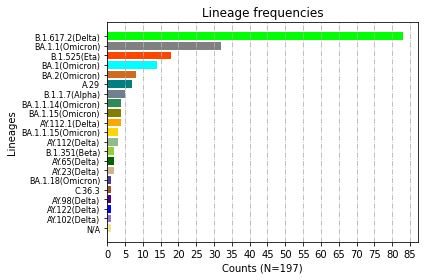

In [63]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=True)

colors = [lin_clrs[lin.split('(')[0].rstrip()] for lin in list(width.index)]
# colors = [clr[1] for clr in clr_code.values()]
n = lins.sum()
xticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts()
#  .sort_values(ascending=False)
plt.barh(width.index, width, color=colors)
plt.title('Lineage frequencies')
plt.ylabel('Lineages')
plt.xticks(xticks, xticks)
plt.yticks(width.index, fontsize=8)
plt.xlabel(f'Counts (N={n})')
plt.grid('major', axis='x', ls='-.')
plt.tight_layout()
# fig.savefig(f'{parent_dir}/**/PlotsFigures', recursive=True)[0]}/policy-brief-Ph-{tech}_{dt}.svg")

# plt.show()

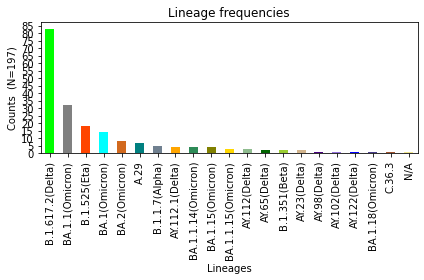

In [64]:
import math
# plot lineage frequencies
width = lins.sort_values(ascending=False)

colors = [lin_clrs[lin.split('(')[0].rstrip()] for lin in list(width.index)]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots(figsize=(6, 4))
# (df_report_fnl['Pango Lineage Annotation']
#  .value_counts().
width.plot(kind='bar', ax=ax, color=colors)
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=width.index)
plt.ylabel(f'Counts  (N={n})')
plt.tight_layout()
# fig.savefig(f'{parent_dir}/**/PlotsFigures', recursive=True)[0]}/policy-brief-Pv-{tech}_{dt}.svg")

# plt.show()

In [65]:
row_order = df_report_fnl.groupby('Sample County of Origin').count()[['Sequence Name']].sort_values('Sequence Name', ascending=False).index

In [66]:
df_report_fnl['Sample County of Origin'] = pd.Categorical(df_report_fnl['Sample County of Origin'], categories=row_order,ordered=True)

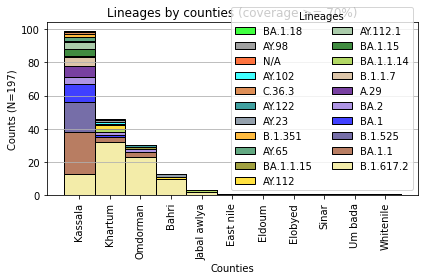

In [67]:
df_seq_summ10Ls_srt = df_report_fnl.rename(columns={'Pango Lineage Annotation':'Lineages'})#.sort_values('Sample County of Origin', ascending=False)
fig,ax = plt.subplots(figsize=(6,4))
# sns.set_palette(sns.color_palette(colors.values()))
palette_clr = colors# {l: colors[l] for l in df_seq_summ10Ls_srt.Lineages.unique()}
# sns.set_color_codes('pastel')
sns.histplot(df_seq_summ10Ls_srt, x='Sample County of Origin', 
            hue='Lineages',multiple="stack",
             hue_order=reversed(df_report_fnl['Pango Lineage Annotation'].value_counts().index),
           palette=palette_clr, ax=ax, legend=True)#legend=True, loc='upper right',title='Lineages', ncol=1, borderaxespad=0
# ax.get_legend()
l = ax.get_legend()
h = l.legendHandles
rotation = 0 if df_seq_summ10Ls_srt.shape[0] < 5 else 90
plt.xticks(rotation=rotation)
plt.ylabel(f'Counts (N={df_seq_summ10Ls_srt.shape[0]})')
plt.xlabel('Counties')
# l.remove()
plt.legend(h, [t.get_text() for t in l.texts], title='Lineages', fancybox=True, ncol=2)#, loc=(1.01, 0.03)labelspacing=0.25, 
# plt.legend(df_seq_summ10Ls_srt.LIN.value_counts().sort_values(ascending=True)[-10:].index,
#           title='Lineages', ncol=1)#, bbox_to_anchor=(1,1)
plt.title('Lineages by counties (coverage >= 70%)', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
# plt.savefig(f"{glob.glob(f'{parent_dir}/**/KnowledgeBrief', recursive=True)[0]}/policy-linXcounty_{seq_name}_{dt}.{ext}")

# plt.show()